In [1]:
import warnings
from requests.exceptions import RequestsDependencyWarning

# Suppress only the noisy warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*RequestsDependencyWarning.*")
warnings.filterwarnings("ignore", category=RequestsDependencyWarning)

d:\College\Anaconda\envs\gpuacc\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

In [3]:
# ======================
# Build classification DataFrames
# ======================
def create_classification_df(base_dir):
    true_dir = os.path.join(base_dir, "true")
    false_dir = os.path.join(base_dir, "false")

    classification_data = []

    # Collect true images
    for fname in os.listdir(true_dir):
        fpath = os.path.join(true_dir, fname)
        if os.path.isfile(fpath):
            classification_data.append([fpath, 1])   # label = 1

    # Collect false images
    for fname in os.listdir(false_dir):
        fpath = os.path.join(false_dir, fname)
        if os.path.isfile(fpath):
            classification_data.append([fpath, 0])  # label = 0

    # Create DataFrame
    cls_df = pd.DataFrame(classification_data, columns=["image_path", "label"])
    cls_df = cls_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return cls_df


# ======================
# Main dataset paths
# ======================
train_dir = r"D:\\Graduation Project\\data\\Video\\Frames\\Training\\labeled"
val_dir   = r"D:\\Graduation Project\\data\\Video\\Frames\\Validation\\labeled"
test_dir  = r"D:\\Graduation Project\\data\\Video\\Frames\\Testing\\labeled"

train_cls_df = create_classification_df(train_dir)
val_cls_df   = create_classification_df(val_dir)
test_cls_df  = create_classification_df(test_dir)

# ======================
# Save DataFrames
# ======================
train_cls_df.to_csv("train_classification.csv", index=False)
val_cls_df.to_csv("val_classification.csv", index=False)
test_cls_df.to_csv("test_classification.csv", index=False)


# ======================
# Info
# ======================
print("Classification DFs:", len(train_cls_df), len(val_cls_df), len(test_cls_df))

Classification DFs: 1136 224 209


In [4]:
train_cls_df.head()

,image_path,label
0,D:\\Graduation Project\\data\\Video\\Frames\\T...,0
1,D:\\Graduation Project\\data\\Video\\Frames\\T...,0
2,D:\\Graduation Project\\data\\Video\\Frames\\T...,1
3,D:\\Graduation Project\\data\\Video\\Frames\\T...,0
4,D:\\Graduation Project\\data\\Video\\Frames\\T...,1


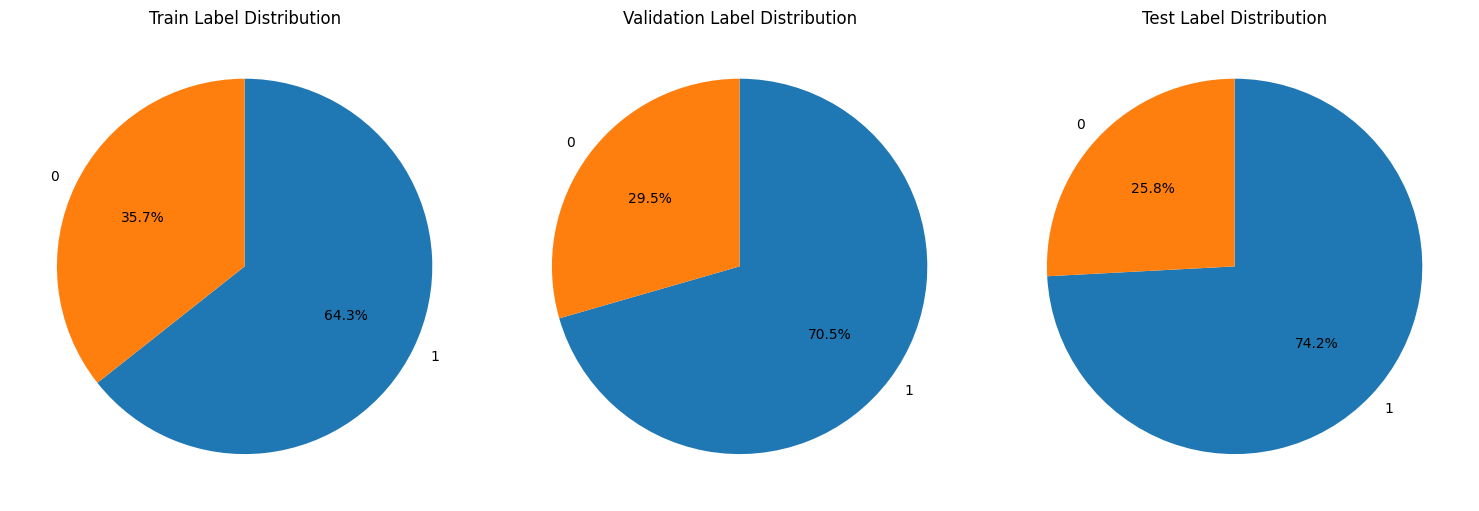

In [5]:
dfs = {
    "Train": train_cls_df,
    "Validation": val_cls_df,
    "Test": test_cls_df
}

plt.figure(figsize=(15, 5))

for i, (name, df) in enumerate(dfs.items(), 1):
    label_counts = df['label'].value_counts()

    plt.subplot(1, 3, i)  # 1 row, 3 columns, i-th plot
    plt.pie(
        label_counts,
        labels=label_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
    plt.title(f"{name} Label Distribution")

plt.tight_layout()
plt.show()

In [6]:
# ------------------------
# Preprocessing / Augmentation
# ------------------------
def preprocess(img, label, img_size=(224,224)):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)   # Convert to RGB
    img = tf.image.resize(img, img_size)
    return img, label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tfa.image.rotate(img, tf.random.uniform([], -0.261, 0.261))  # ~ -15° to +15°
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label

def normalize(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# ------------------------
# Dataset builder
# ------------------------
def make_dataset(df, img_size=(224,224), batch_size=4, do_augment=False, shuffle=False, preprocess_fn=None):
    paths = df["image_path"].values
    labels = df["label"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)

    # base preprocessing (resize, decode)
    ds = ds.map(lambda x, y: preprocess(x, y, img_size), num_parallel_calls=tf.data.AUTOTUNE)

    # augment only on train set
    if do_augment:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    # normalization: either custom (/255.0) or keras preprocess_input
    if preprocess_fn is not None:
        ds = ds.map(lambda x, y: (preprocess_fn(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# ResNet datasets
train_ds_resnet = make_dataset(train_cls_df, img_size=(224,224), batch_size=4,
                               do_augment=True, shuffle=True, preprocess_fn=resnet_preprocess)
val_ds_resnet = make_dataset(val_cls_df, img_size=(224,224), batch_size=4,
                             do_augment=False, shuffle=False, preprocess_fn=resnet_preprocess)
test_ds_resnet = make_dataset(test_cls_df, img_size=(224,224), batch_size=4,
                              do_augment=False, shuffle=False, preprocess_fn=resnet_preprocess)

# DenseNet datasets
train_ds_densenet = make_dataset(train_cls_df, img_size=(224,224), batch_size=4,
                                 do_augment=True, shuffle=True, preprocess_fn=densenet_preprocess)
val_ds_densenet = make_dataset(val_cls_df, img_size=(224,224), batch_size=4,
                               do_augment=False, shuffle=False, preprocess_fn=densenet_preprocess)
test_ds_densenet = make_dataset(test_cls_df, img_size=(224,224), batch_size=4,
                                do_augment=False, shuffle=False, preprocess_fn=densenet_preprocess)

print("✅ Datasets ready:")

✅ Datasets ready:


In [7]:
# =========================
# 1. Model builder function
# =========================
def build_model(base_model, input_shape):
    base_model.trainable = False  # freeze base model initially
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# =========================
# 2. Training and evaluation function
# =========================
def train_and_evaluate(model_name, base_model, train_ds, val_ds, test_ds, input_shape, epochs=50):
    print(f"\n🔹 Training {model_name}...")
    model = build_model(base_model, input_shape)
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    checkpoint = ModelCheckpoint(
        f'best_{model_name}_freezed.h5',
        monitor='val_loss',
        save_best_only=True
    )
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop, checkpoint]
    )
    
    print(f"\n✅ Evaluating {model_name}...")
    results = model.evaluate(test_ds, verbose=0)
    test_loss, test_acc = results[0], results[1]
    print(f"{model_name} Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    # =========================
    # Predictions
    # =========================
    y_true = np.concatenate([y for _, y in test_ds], axis=0)   # ground truth labels
    y_pred_probs = model.predict(test_ds)
    y_pred = (y_pred_probs > 0.5).astype("int32").ravel()
    
    # =========================
    # Classification report
    # =========================
    print(f"\n📊 Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, digits=4))
    
    # =========================
    # Extra metrics
    # =========================
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)
    acc = accuracy_score(y_true, y_pred)
    
    print(f"\n📈 Extra Evaluation Metrics for {model_name}:")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Precision  : {precision:.4f}")
    print(f"Recall     : {recall:.4f}")
    print(f"F1-score   : {f1:.4f}")
    print(f"AUC        : {auc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\n🌀 Confusion Matrix:")
    print(cm)
    
    # return model, history, and accuracy
    return model, history, test_acc

# =========================
# 3. Prepare base models
# =========================
# ResNet50 (224x224)
resnet_base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

# DenseNet121 (224x224)
densenet_base = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224,3))

# =========================
# 4. Train models
# =========================
resnet_model_freezed, resnet_history_freezed, resnet_acc_freezed = train_and_evaluate(
    "ResNet50", resnet_base, train_ds_resnet, val_ds_resnet, test_ds_resnet, (224,224,3)
)

densenet_model_freezed, densenet_history_freezed, densenet_acc_freezed = train_and_evaluate(
    "DenseNet121", densenet_base, train_ds_densenet, val_ds_densenet, test_ds_densenet, (224,224,3)
)

print("✅ Final Accuracies:")
print("ResNet50:", resnet_acc_freezed)
print("DenseNet121:", densenet_acc_freezed)


🔹 Training ResNet50...
Epoch 1/50
284/284 [==============================] - 17s 37ms/step - loss: 0.3852 - accuracy: 0.8460 - val_loss: 0.2666 - val_accuracy: 0.8750
Epoch 2/50
284/284 [==============================] - 13s 44ms/step - loss: 0.2646 - accuracy: 0.8829 - val_loss: 0.1938 - val_accuracy: 0.9062
Epoch 3/50
284/284 [==============================] - 13s 45ms/step - loss: 0.2189 - accuracy: 0.9102 - val_loss: 0.1795 - val_accuracy: 0.9062
Epoch 4/50
284/284 [==============================] - 13s 45ms/step - loss: 0.2072 - accuracy: 0.9199 - val_loss: 0.1494 - val_accuracy: 0.9375
Epoch 5/50
284/284 [==============================] - 13s 44ms/step - loss: 0.1808 - accuracy: 0.9208 - val_loss: 0.1110 - val_accuracy: 0.9598
Epoch 6/50
284/284 [==============================] - 9s 33ms/step - loss: 0.1867 - accuracy: 0.9269 - val_loss: 0.1406 - val_accuracy: 0.9330
Epoch 7/50
284/284 [==============================] - 12s 44ms/step - loss: 0.1705 - accuracy: 0.9331 - val_loss:

In [8]:
# =========================
# 1. Model builder function
# =========================
def build_model(base_model, input_shape):
    base_model.trainable = True  # unfreeze base model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# =========================
# 2. Training and evaluation function
# =========================
def train_and_evaluate(model_name, base_model, train_ds, val_ds, test_ds, input_shape, epochs=50):
    print(f"\n🔹 Training {model_name}...")
    model = build_model(base_model, input_shape)
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    checkpoint = ModelCheckpoint(
        f'best_{model_name}_unfreezed.h5',
        monitor='val_loss',
        save_best_only=True
    )
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop, checkpoint]
    )
    
    print(f"\n✅ Evaluating {model_name}...")
    results = model.evaluate(test_ds, verbose=0)
    test_loss, test_acc = results[0], results[1]
    print(f"{model_name} Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    # =========================
    # Predictions
    # =========================
    y_true = np.concatenate([y for _, y in test_ds], axis=0)   # ground truth labels
    y_pred_probs = model.predict(test_ds)
    y_pred = (y_pred_probs > 0.5).astype("int32").ravel()
    
    # =========================
    # Classification report
    # =========================
    print(f"\n📊 Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, digits=4))
    
    # =========================
    # Extra metrics
    # =========================
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)
    acc = accuracy_score(y_true, y_pred)
    
    print(f"\n📈 Extra Evaluation Metrics for {model_name}:")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Precision  : {precision:.4f}")
    print(f"Recall     : {recall:.4f}")
    print(f"F1-score   : {f1:.4f}")
    print(f"AUC        : {auc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\n🌀 Confusion Matrix:")
    print(cm)
    
    # return model, history, and accuracy
    return model, history, test_acc

# =========================
# 3. Prepare base models
# =========================
# ResNet50 (224x224)
resnet_base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

# DenseNet121 (224x224)
densenet_base = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224,3))

# =========================
# 4. Train models
# =========================
resnet_model_unfreezed, resnet_history_unfreezed, resnet_acc_unfreezed = train_and_evaluate(
    "ResNet50", resnet_base, train_ds_resnet, val_ds_resnet, test_ds_resnet, (224,224,3)
)

densenet_model_unfreezed, densenet_history_unfreezed, densenet_acc_unfreezed = train_and_evaluate(
    "DenseNet121", densenet_base, train_ds_densenet, val_ds_densenet, test_ds_densenet, (224,224,3)
)

print("✅ Final Accuracies:")
print("ResNet50:", resnet_acc_unfreezed)
print("DenseNet121:", densenet_acc_unfreezed)


🔹 Training ResNet50...
Epoch 1/50
284/284 [==============================] - 36s 106ms/step - loss: 0.2913 - accuracy: 0.8847 - val_loss: 0.0965 - val_accuracy: 0.9688
Epoch 2/50
284/284 [==============================] - 29s 100ms/step - loss: 0.1298 - accuracy: 0.9551 - val_loss: 0.1393 - val_accuracy: 0.9732
Epoch 3/50
284/284 [==============================] - 37s 131ms/step - loss: 0.1132 - accuracy: 0.9674 - val_loss: 0.0386 - val_accuracy: 0.9911
Epoch 4/50
284/284 [==============================] - 29s 100ms/step - loss: 0.0765 - accuracy: 0.9718 - val_loss: 0.0707 - val_accuracy: 0.9866
Epoch 5/50
284/284 [==============================] - 28s 100ms/step - loss: 0.0705 - accuracy: 0.9780 - val_loss: 0.0698 - val_accuracy: 0.9821
Epoch 6/50
284/284 [==============================] - 38s 133ms/step - loss: 0.0569 - accuracy: 0.9815 - val_loss: 0.0252 - val_accuracy: 0.9911
Epoch 7/50
284/284 [==============================] - 29s 100ms/step - loss: 0.0517 - accuracy: 0.9815 - v